This notebook is about the benchmark model (Establishing a baseline benchmark model to compare against the final NN model and evaluating it.).

In [2]:
import numpy as np
import matplotlib.pyplot as plt #for displaying plots
import pandas as pd
import seaborn as sns
import tensorflow as tf
import datetime
import random
import properscoring as ps
from scipy import stats
import os
from pathlib import Path

# Setup

In [3]:
# setting a seed to ensure reproducability and consistency
random.seed(16)
np.random.seed(16)
tf.random.set_seed(16)

In [4]:
# Change Working Directory
os.chdir("..")
print(os.getcwd()) # print current working directory

c:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Probabilistic-Forecasting-of-Bicycle-Counts-in-Karlsruhe-with-Neural-Networks


In [5]:
plt.rcParams.update({'font.size': 14})
sns.set_context("notebook", font_scale=1.4, rc={"axes.linewidth": 0.8, "lines.linewidth": 1})


In [6]:
df_train = pd.read_csv(r"data\df_train.csv")

In [7]:
df_test = pd.read_csv(r"data\df_test.csv")

In [8]:
#save a copy of the raw data
df_train_raw = df_train.copy()
df_test_raw = df_test.copy()

In [9]:
df_train['date'] = pd.to_datetime(df_train['date'])
df_test['date'] = pd.to_datetime(df_test['date'])

# Benchmarking

## Functions

In [10]:
# Function to filter bike counts by
def filter_bike_counts_by(df, column, column_value):
    bike_counts_df = df[df[column] == column_value]
    return bike_counts_df

In [11]:
# function to create a probability distribution array (probability distribution repeated for number of observations)
def create_prob_distribution_array(array, num_observations):

    # Repeat the bike counts to create a 2D array
    bike_counts = array['bike_count'].values
    prob_distribution_2d = np.tile(bike_counts, (num_observations, 1))

    return prob_distribution_2d



In [12]:
def split_by_weekdays(df_train, df_test):
    df_train_mondays = filter_bike_counts_by(df_train, 'day_of_week', 0) #monday
    df_train_tuesdays = filter_bike_counts_by(df_train, 'day_of_week', 1) #tuesday
    df_train_wednesdays = filter_bike_counts_by(df_train, 'day_of_week', 2) #wednesday
    df_train_thursdays = filter_bike_counts_by(df_train, 'day_of_week', 3) #thursday
    df_train_fridays = filter_bike_counts_by(df_train, 'day_of_week', 4) #friday
    df_train_saturdays = filter_bike_counts_by(df_train, 'day_of_week', 5) #saturday
    df_train_sundays = filter_bike_counts_by(df_train, 'day_of_week', 6) #sunday

    df_test_mondays = filter_bike_counts_by(df_test, 'day_of_week', 0) #monday
    df_test_tuesdays = filter_bike_counts_by(df_test, 'day_of_week', 1) #tuesday
    df_test_wednesdays = filter_bike_counts_by(df_test, 'day_of_week', 2) #wednesday
    df_test_thursdays = filter_bike_counts_by(df_test, 'day_of_week', 3) #thursday
    df_test_fridays = filter_bike_counts_by(df_test, 'day_of_week', 4) #friday
    df_test_saturdays = filter_bike_counts_by(df_test, 'day_of_week', 5) #saturday
    df_test_sundays = filter_bike_counts_by(df_test, 'day_of_week', 6) #sunday

    
    return (df_train_mondays, df_test_mondays), (df_train_tuesdays, df_test_tuesdays), (df_train_wednesdays, df_test_wednesdays), (df_train_thursdays, df_test_thursdays), (df_train_fridays, df_test_fridays), (df_train_saturdays, df_test_saturdays), (df_train_sundays, df_test_sundays)

In [13]:
def split_by_workdays(df_train, df_test):

    df_train_workdays = filter_bike_counts_by(df_train, 'is_workday', 1) #workday
    df_train_non_workdays = filter_bike_counts_by(df_train, 'is_workday', 0) #non-workday

    df_test_workdays = filter_bike_counts_by(df_test, 'is_workday', 1) #workday
    df_test_non_workdays = filter_bike_counts_by(df_test, 'is_workday', 0) #non-workday

    return (df_train_workdays, df_test_workdays), (df_train_non_workdays, df_test_non_workdays)

In [14]:
def split_by_seasons(df_train, df_test):

    df_train_spring = filter_bike_counts_by(df_train, 'season', 0) #spring
    df_train_summer = filter_bike_counts_by(df_train, 'season', 1) #summer
    df_train_autumn = filter_bike_counts_by(df_train, 'season', 2) #autumn
    df_train_winter = filter_bike_counts_by(df_train, 'season', 3) #winter

    df_test_spring = filter_bike_counts_by(df_test, 'season', 0) #spring
    df_test_summer = filter_bike_counts_by(df_test, 'season', 1) #summer
    df_test_autumn = filter_bike_counts_by(df_test, 'season', 2) #autumn
    df_test_winter = filter_bike_counts_by(df_test, 'season', 3) #winter

    return (df_train_spring, df_test_spring), (df_train_summer, df_test_summer), (df_train_autumn, df_test_autumn), (df_train_winter, df_test_winter)

In [15]:
def split_by_public_holiday(df_train, df_test):
    
    df_train_ph = filter_bike_counts_by(df_train, 'public_holiday_indicator', 1) #ph
    df_train_no_ph = filter_bike_counts_by(df_train, 'public_holiday_indicator', 0) #no ph

    df_test_ph = filter_bike_counts_by(df_test, 'public_holiday_indicator', 1) #ph
    df_test_no_ph = filter_bike_counts_by(df_test, 'public_holiday_indicator', 0) #no ph

    return (df_train_ph, df_test_ph), (df_train_no_ph, df_test_no_ph)

In [16]:
def split_by_school_holiday(df_train, df_test):
    
    df_train_schoolh = filter_bike_counts_by(df_train, 'school_holiday_indicator', 1) #schoolh
    df_train_no_schoolh = filter_bike_counts_by(df_train, 'school_holiday_indicator', 0) #no schoolh

    df_test_schoolh = filter_bike_counts_by(df_test, 'school_holiday_indicator', 1) #schoolh
    df_test_no_schoolh = filter_bike_counts_by(df_test, 'school_holiday_indicator', 0) #no schoolh

    return (df_train_schoolh, df_test_schoolh), (df_train_no_schoolh, df_test_no_schoolh)

In [17]:
def split_by_rain_indic(df_train, df_test):
    
    df_train_rain = filter_bike_counts_by(df_train, 'precip_indic', 1) #rain
    df_train_no_rain = filter_bike_counts_by(df_train, 'precip_indic', 0) #no rain

    df_test_rain = filter_bike_counts_by(df_test, 'precip_indic', 1) #rain
    df_test_no_rain = filter_bike_counts_by(df_test, 'precip_indic', 0) #no rain

    return (df_train_rain, df_test_rain), (df_train_no_rain, df_test_no_rain)

In [18]:
def split_by_temperature(df_train, df_test):
    df_train_cold = df_train[df_train['temperature'] < 10]
    df_train_mild = df_train[(df_train['temperature'] >= 10) & (df_train['temperature'] < 20)]
    df_train_warm = df_train[df_train['temperature'] >= 20]

    df_test_cold = df_test[df_test['temperature'] < 10]
    df_test_mild = df_test[(df_test['temperature'] >= 10) & (df_test['temperature'] < 20)]
    df_test_warm = df_test[df_test['temperature'] >= 20]

    return (df_train_cold, df_test_cold), (df_train_mild, df_test_mild), (df_train_warm, df_test_warm)

In [19]:
def split_by_windspeed_quantiles(df_train, df_test):
    # Compute quantiles from training data
    quantiles = df_train['windspeed'].quantile([0.25, 0.5, 0.75]).values

    # Define function to segment data by wind speed
    def filter_by_windspeed(df, col='windspeed'):
        return {
            "low": df[df[col] <= quantiles[0]],
            "medium-low": df[(df[col] > quantiles[0]) & (df[col] <= quantiles[1])],
            "medium-high": df[(df[col] > quantiles[1]) & (df[col] <= quantiles[2])],
            "high": df[df[col] > quantiles[2]]
        }

    # Apply function to train and test sets
    train_splits = filter_by_windspeed(df_train)
    test_splits = filter_by_windspeed(df_test)

    return (train_splits["low"], test_splits["low"]), \
           (train_splits["medium-low"], test_splits["medium-low"]), \
           (train_splits["medium-high"], test_splits["medium-high"]), \
           (train_splits["high"], test_splits["high"])

In [20]:
def calculate_crps(dfs_split):
    crps = []
    for df_train, df_test in dfs_split:
        prob_distribution = create_prob_distribution_array(df_train, len(df_test))
        crps.append(ps.crps_ensemble(df_test['bike_count'].values, prob_distribution))

    crps_flattened = np.hstack(crps)
    mean_crps = np.mean(crps_flattened)
    print(mean_crps)
    
    return mean_crps

In [21]:
crps_all = calculate_crps([(df_train, df_test)])

963.4204751278805


## Splits

### One split

In [22]:
dfs_split_by_weekdays = split_by_weekdays(df_train, df_test)

In [23]:
crps_all_weekdays = calculate_crps(dfs_split_by_weekdays)

682.4008120692448


In [24]:
dfs_split_by_workdays = split_by_workdays(df_train, df_test)

In [25]:
crps_all_workdays = calculate_crps(dfs_split_by_workdays)

687.1098887023528


In [26]:
dfs_split_by_seasons = split_by_seasons(df_train, df_test)

In [27]:
crps_all_seasons = calculate_crps(dfs_split_by_seasons)

871.9014768514124


In [28]:
dfs_split_by_public_holiday = split_by_public_holiday(df_train, df_test)

In [29]:
crps_ph = calculate_crps(dfs_split_by_public_holiday)

904.4977369647643


In [30]:
dfs_split_by_school_holiday = split_by_school_holiday(df_train, df_test)

In [31]:
crps_schoolh = calculate_crps(dfs_split_by_school_holiday)

964.4560064911091


In [32]:
dfs_split_by_rain_indic = split_by_rain_indic(df_train, df_test)

In [33]:
crps_rain = calculate_crps(dfs_split_by_rain_indic)

932.3026087459031


In [34]:
dfs_split_by_temperature = split_by_temperature(df_train, df_test)

In [35]:
crps_temperature = calculate_crps(dfs_split_by_temperature)

900.2179182717732


In [36]:
dfs_split_by_windspeed_quantiles = split_by_windspeed_quantiles(df_train, df_test)

In [37]:
crps_windspeed = calculate_crps(dfs_split_by_windspeed_quantiles)

952.1193440463846


### Split workdays further

#### 2 segments

In [38]:
# split the data by workdays and seasons
dfs_split_by_workdays_and_seasons = []

for df_train_workdays, df_test_workdays in dfs_split_by_workdays:
    dfs_split_by_seasons = split_by_seasons(df_train_workdays, df_test_workdays)
    for season_split in dfs_split_by_seasons:
        dfs_split_by_workdays_and_seasons.append(season_split)

In [39]:
crps_all_workdays_and_seasons = calculate_crps(dfs_split_by_workdays_and_seasons)

567.9864204619457


In [40]:
dfs_split_by_workdays_and_public_holiday = []

for df_train1, df_test1 in dfs_split_by_workdays:
    dfs_split_by_public_holiday = split_by_public_holiday(df_train1, df_test1)
    for public_holiday_split in dfs_split_by_public_holiday:
        dfs_split_by_workdays_and_public_holiday.append(public_holiday_split)

In [41]:
crps_workdays_ph = calculate_crps(dfs_split_by_workdays_and_public_holiday)

674.7819199045066


In [42]:
dfs_split_by_workdays_and_school_holiday = []

for df_train1, df_test1 in dfs_split_by_workdays:
    dfs_split_by_school_holiday = split_by_school_holiday(df_train1, df_test1)
    for school_holiday_split in dfs_split_by_school_holiday:
        dfs_split_by_workdays_and_school_holiday.append(school_holiday_split)

In [43]:
crps_workdays_schoolh = calculate_crps(dfs_split_by_workdays_and_school_holiday)

687.9200117203204


In [44]:
# split the data by workdays and rain

dfs_split_by_workdays_and_rain = []

for df_train2, df_test2 in dfs_split_by_workdays:
    dfs_split_by_rain_indic = split_by_rain_indic(df_train2, df_test2)
    for rain_split in dfs_split_by_rain_indic:
        dfs_split_by_workdays_and_rain.append(rain_split)

In [45]:
crps_all_workdays_and_rain = calculate_crps(dfs_split_by_workdays_and_rain)

635.7721467362363


In [46]:
dfs_split_by_workdays_and_temperature = []

for df_train3, df_test3 in dfs_split_by_workdays:
    dfs_split_by_temperature = split_by_temperature(df_train3, df_test3)
    for temperature_split in dfs_split_by_temperature:
        dfs_split_by_workdays_and_temperature.append(temperature_split)
crps_all_workdays_and_temperature = calculate_crps(dfs_split_by_workdays_and_temperature)

589.0072054478144


#### 3 segments

In [47]:
# split the data by workdays, season and rain indicator

dfs_split_by_workdays_season_and_rain = []

for df_trains, df_tests in dfs_split_by_workdays_and_seasons:
    dfs_split_by_rain_indic = split_by_rain_indic(df_trains, df_tests)
    for rain_split in dfs_split_by_rain_indic:
        dfs_split_by_workdays_season_and_rain.append(rain_split)

In [48]:
crps_all_workdays_and_seasons_and_rain = calculate_crps(dfs_split_by_workdays_season_and_rain)

516.1053105979322


In [49]:
dfs_split_by_workdays_season_rain_ph = []

for df_trains, df_tests in dfs_split_by_workdays_and_seasons:
    dfs_split_by_public_holiday = split_by_public_holiday(df_trains, df_tests)
    for ph_split in dfs_split_by_public_holiday:
        dfs_split_by_workdays_season_rain_ph.append(ph_split)

crps_all_workdays_and_seasons_and_rain_ph = calculate_crps(dfs_split_by_workdays_season_rain_ph)

557.7345808377271


In [50]:
dfs_split_by_workdays_season_rain_ph_schoolh = []

for df_trains, df_tests in dfs_split_by_workdays_and_seasons:
    dfs_split_by_school_holiday = split_by_school_holiday(df_trains, df_tests)
    for schoolh_split in dfs_split_by_school_holiday:
        dfs_split_by_workdays_season_rain_ph_schoolh.append(schoolh_split)

crps_all_workdays_and_seasons_and_rain_ph_schoolh = calculate_crps(dfs_split_by_workdays_season_rain_ph_schoolh)

526.374788901415


In [51]:
dfs_split_by_workdays_temperature_and_rain = []

for df_train4, df_test4 in dfs_split_by_workdays_and_rain:
    dfs_split_by_rain_indic = split_by_rain_indic(df_train4, df_test4)
    for rain_split in dfs_split_by_rain_indic:
        dfs_split_by_workdays_temperature_and_rain.append(rain_split)
crps_all_workdays_temperature_and_rain = calculate_crps(dfs_split_by_workdays_temperature_and_rain)

635.7721467362363


In [52]:
dfs_split_by_workdays_season_rain_ph_schoolh_temperature = []

for df_trains, df_tests in dfs_split_by_workdays_and_seasons:
    dfs_split_by_temperature = split_by_temperature(df_trains, df_tests)
    for temperature_split in dfs_split_by_temperature:
        dfs_split_by_workdays_season_rain_ph_schoolh_temperature.append(temperature_split)

crps_all_workdays_and_seasons_and_rain_ph_schoolh_temperature = calculate_crps(dfs_split_by_workdays_season_rain_ph_schoolh_temperature)

559.0803048578567


In [53]:
dfs_split_by_workdays_season_rain_ph_schoolh_temperature_windspeed = []

for df_trains, df_tests in dfs_split_by_workdays_season_rain_ph_schoolh_temperature:
    dfs_split_by_windspeed_quantiles = split_by_windspeed_quantiles(df_trains, df_tests)
    for windspeed_split in dfs_split_by_windspeed_quantiles:
        dfs_split_by_workdays_season_rain_ph_schoolh_temperature_windspeed.append(windspeed_split)

crps_all_workdays_and_seasons_and_rain_ph_schoolh_temperature_windspeed = calculate_crps(dfs_split_by_workdays_season_rain_ph_schoolh_temperature_windspeed)

554.7023942878767


In [54]:
dfs_split_by_work_and_weekdays_all_weather = []

for df_train5, df_test5 in dfs_split_by_workdays_temperature_and_rain:
    dfs_split_by_weekday = split_by_weekdays(df_train5, df_test5)
    for weekday_split in dfs_split_by_weekday:
        dfs_split_by_work_and_weekdays_all_weather.append(weekday_split)
crps_all_work_and_weekdays_all_weather = calculate_crps(dfs_split_by_work_and_weekdays_all_weather)

554.935759897626


In [55]:
dfs_split_by_workdays_temp_rain_ph = []

for df_train6, df_test6 in dfs_split_by_workdays_temperature_and_rain:
    dfs_split_by_public_holiday = split_by_public_holiday(df_train6, df_test6)
    for public_holiday_split in dfs_split_by_public_holiday:
        dfs_split_by_workdays_temp_rain_ph.append(public_holiday_split)
crps_all_workdays_temp_rain_ph = calculate_crps(dfs_split_by_workdays_temp_rain_ph)

625.4473396687653


### Weekday splits

In [56]:
dfs_split_by_weekdays_ph = []

for df_train7, df_test7 in dfs_split_by_weekdays:
    dfs_split_by_public_holiday = split_by_public_holiday(df_train7, df_test7)
    for public_holiday_split in dfs_split_by_public_holiday:
        dfs_split_by_weekdays_ph.append(public_holiday_split)

crps_all_weekdays_ph = calculate_crps(dfs_split_by_weekdays_ph)

604.2131583286331


In [57]:
dfs_split_by_weekdays_ph_schoolh = []

for df_train8, df_test8 in dfs_split_by_weekdays_ph:
    dfs_split_by_school_holiday = split_by_school_holiday(df_train8, df_test8)
    for school_holiday_split in dfs_split_by_school_holiday:
        dfs_split_by_weekdays_ph_schoolh.append(school_holiday_split)

crps_all_weekdays_ph_schoolh = calculate_crps(dfs_split_by_weekdays_ph_schoolh)

607.4623942316517


In [58]:
dfs_split_by_weekdays_ph_schoolh_season = []

for df_train9, df_test9 in dfs_split_by_weekdays_ph_schoolh:
    dfs_split_by_seasons = split_by_seasons(df_train9, df_test9)
    for season_split in dfs_split_by_seasons:
        dfs_split_by_weekdays_ph_schoolh_season.append(season_split)

crps_all_weekdays_ph_schoolh_season = calculate_crps(dfs_split_by_weekdays_ph_schoolh_season)

437.35357819083094


In [59]:
dfs_split_by_weekdays_ph_schoolh_season_wind = []

for df_train10, df_test10 in dfs_split_by_weekdays_ph_schoolh_season:
    dfs_split_by_windspeed_quantiles = split_by_windspeed_quantiles(df_train10, df_test10)
    for windspeed_split in dfs_split_by_windspeed_quantiles:
        dfs_split_by_weekdays_ph_schoolh_season_wind.append(windspeed_split)


crps_all_weekdays_ph_schoolh_season_wind = calculate_crps(dfs_split_by_weekdays_ph_schoolh_season_wind)

462.11794468183115


In [60]:
dfs_split_by_weekdays_ph_schoolh_rain = []

for df_train10, df_test10 in dfs_split_by_weekdays_ph_schoolh:
    dfs_split_by_rain_indic = split_by_rain_indic(df_train10, df_test10)
    for rain_split in dfs_split_by_rain_indic:
        dfs_split_by_weekdays_ph_schoolh_rain.append(rain_split)

crps_all_weekdays_ph_schoolh_rain = calculate_crps(dfs_split_by_weekdays_ph_schoolh_rain)


551.2492379535302


In [61]:
# split the data by workdays and seasons
dfs_split_by_weekdays_and_seasons = []

for df_train_weekdays, df_test_weekdays in dfs_split_by_weekdays:
    dfs_split_by_seasons = split_by_seasons(df_train_weekdays, df_test_weekdays)
    for season_split in dfs_split_by_seasons:
        dfs_split_by_weekdays_and_seasons.append(season_split)

In [62]:
crps_all_weekdays_and_seasons = calculate_crps(dfs_split_by_weekdays_and_seasons)

552.5523182632193


In [63]:
dfs_split_by_weekdays_season_and_rain = []

for df_trains, df_tests in dfs_split_by_weekdays_and_seasons:
    dfs_split_by_rain_indic = split_by_rain_indic(df_trains, df_tests)
    for rain_split in dfs_split_by_rain_indic:
        dfs_split_by_weekdays_season_and_rain.append(rain_split)

In [64]:
crps_all_weekdays_and_seasons_and_rain = calculate_crps(dfs_split_by_weekdays_season_and_rain)

496.2950220144236


In [65]:
dfs_split_by_weekdays_season_rain_and_wind = []

for df_trains, df_tests in dfs_split_by_weekdays_season_and_rain:
    dfs_split_by_windspeed_quantiles = split_by_windspeed_quantiles(df_trains, df_tests)
    for windspeed_split in dfs_split_by_windspeed_quantiles:
        dfs_split_by_weekdays_season_rain_and_wind.append(windspeed_split)

crps_all_weekdays_and_seasons_and_rain_and_wind = calculate_crps(dfs_split_by_weekdays_season_rain_and_wind)	

514.0750247128441


In [66]:
dfs_split_by_weekdays_season_rain_and_temperature = []

for df_train7, df_test7 in dfs_split_by_weekdays_season_and_rain:
    dfs_split_by_temperature = split_by_temperature(df_train7, df_test7)
    for temperature_split in dfs_split_by_temperature:
        dfs_split_by_weekdays_season_rain_and_temperature.append(temperature_split)

crps_all_weekdays_and_seasons_and_rain_and_temperature = calculate_crps(dfs_split_by_weekdays_season_rain_and_temperature)

522.7738390274064


In [67]:
dfs_split_by_weekdays_season_and_rain_ph = []

for df_train8, df_test8 in dfs_split_by_weekdays_season_and_rain:
    dfs_split_by_public_holiday = split_by_public_holiday(df_train8, df_test8)
    for public_holiday_split in dfs_split_by_public_holiday:
        dfs_split_by_weekdays_season_and_rain_ph.append(public_holiday_split)

crps_all_weekdays_and_seasons_and_rain_ph = calculate_crps(dfs_split_by_weekdays_season_and_rain_ph)

424.15565027005


In [68]:
dfs_split_by_weekdays_season_and_rain_workday = []

for df_train8, df_test8 in dfs_split_by_weekdays_season_and_rain:
    dfs_split_by_workday = split_by_workdays(df_train8, df_test8)
    for workday_split in dfs_split_by_workday:
        dfs_split_by_weekdays_season_and_rain_workday.append(workday_split)

crps_all_weekdays_and_seasons_and_rain_workday = calculate_crps(dfs_split_by_weekdays_season_and_rain_workday)

425.25065130344524


In [69]:
dfs_split_by_weekdays_season_rain_schoolh = []

for df_train9, df_test9 in dfs_split_by_weekdays_season_and_rain:
    dfs_split_by_school_holiday = split_by_school_holiday(df_train9, df_test9)
    for school_holiday_split in dfs_split_by_school_holiday:
        dfs_split_by_weekdays_season_rain_schoolh.append(school_holiday_split)

crps_all_weekdays_and_seasons_and_rain_schoolh = calculate_crps(dfs_split_by_weekdays_season_rain_schoolh)

452.1185423085236


In [70]:
dfs_split_by_weekdays_season_and_rain_workday_schoolh = []

for df_train10, df_test10 in dfs_split_by_weekdays_season_and_rain_workday:
    dfs_split_by_school_holiday = split_by_school_holiday(df_train10, df_test10)
    for school_holiday_split in dfs_split_by_school_holiday:
        dfs_split_by_weekdays_season_and_rain_workday_schoolh.append(school_holiday_split)

crps_all_weekdays_and_seasons_and_rain_workday_schoolh = calculate_crps(dfs_split_by_weekdays_season_and_rain_workday_schoolh)

400.52373474029406


In [71]:
dfs_split_by_weekdays_season_and_rain_ph_schoolh = []

for df_train10, df_test10 in dfs_split_by_weekdays_season_and_rain_ph:
    dfs_split_by_school_holiday = split_by_school_holiday(df_train10, df_test10)
    for school_holiday_split in dfs_split_by_school_holiday:
        dfs_split_by_weekdays_season_and_rain_ph_schoolh.append(school_holiday_split)

crps_all_weekdays_and_seasons_and_rain_ph_schoolh = calculate_crps(dfs_split_by_weekdays_season_and_rain_ph_schoolh)

398.8623014258459


In [72]:
dfs_split_by_weekdays_season_rain_ph_schoolh_temp = []

for df_train11, df_test11 in dfs_split_by_weekdays_season_and_rain_ph_schoolh:
    dfs_split_by_temperature = split_by_temperature(df_train11, df_test11)
    for temperature_split in dfs_split_by_temperature:
        dfs_split_by_weekdays_season_rain_ph_schoolh_temp.append(temperature_split)

crps_all_weekdays_and_seasons_and_rain_ph_schoolh_temp = calculate_crps(dfs_split_by_weekdays_season_rain_ph_schoolh_temp)

510.21321884170845


In [73]:
dfs_split_by_weekdays_season_and_rain_ph_schoolh_windspeed = []

for df_train12, df_test12 in dfs_split_by_weekdays_season_and_rain_ph_schoolh:
    dfs_split_by_windspeed_quantiles = split_by_windspeed_quantiles(df_train12, df_test12)
    for windspeed_split in dfs_split_by_windspeed_quantiles:
        dfs_split_by_weekdays_season_and_rain_ph_schoolh_windspeed.append(windspeed_split)

crps_all_weekdays_and_seasons_and_rain_ph_schoolh_windspeed = calculate_crps(dfs_split_by_weekdays_season_and_rain_ph_schoolh_windspeed)

437.7726475474544


In [74]:

dfs_split_by_weekdays_and_rain = []

for df_train2a, df_test2a in dfs_split_by_weekdays:
    dfs_split_by_rain_indic = split_by_rain_indic(df_train2a, df_test2a)
    for rain_split in dfs_split_by_rain_indic:
        dfs_split_by_weekdays_and_rain.append(rain_split)

In [75]:
crps_all_weekdays_and_rain = calculate_crps(dfs_split_by_weekdays_and_rain)

625.9236880469405


In [76]:
len(df_test)

390

In [77]:
dfs_split_by_weekdays_temperature_and_rain = []

for df_train4a, df_test4a in dfs_split_by_weekdays_and_rain:
    dfs_split_by_rain_indic = split_by_rain_indic(df_train4a, df_test4a)
    for rain_split in dfs_split_by_rain_indic:
        dfs_split_by_weekdays_temperature_and_rain.append(rain_split)

In [78]:
df_train.head()

,date,bike_count,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
0,2012-04-25,4593.0,12.038889,65.611111,3.033333,183.333333,53611.111111,0.0,294,12.0,0,No Holiday,0,No Holiday,0,0,1,0,2
1,2012-04-26,5849.0,14.194444,66.111111,2.844444,249.444444,52555.555556,0.0,176,10.0,0,No Holiday,0,No Holiday,0,0,1,0,3
2,2012-04-27,5846.0,15.233333,68.666667,1.505556,235.000000,45055.555556,0.1,373,5.0,1,No Holiday,0,No Holiday,0,0,1,0,4
3,2012-04-28,4261.0,22.200000,53.444444,2.700000,153.888889,41500.000000,0.0,678,8.0,0,No Holiday,0,No Holiday,0,0,0,0,5
4,2012-04-29,1901.0,17.994444,62.222222,3.950000,214.444444,52777.777778,3.7,319,16.0,1,No Holiday,0,No Holiday,0,0,0,0,6


In [79]:
# Group the DataFrame by month and day without considering the year
df_train_grouped_by_day = df_train.groupby([df_train['date'].dt.month, df_train['date'].dt.day])
df_test_grouped_by_day = df_test.groupby([df_test['date'].dt.month, df_test['date'].dt.day])

crps_by_day = []

# Iterate over each group
for (month, day), group_train in df_train_grouped_by_day:
    if (month, day) in df_test_grouped_by_day.groups:
        group_test = df_test_grouped_by_day.get_group((month, day))

        # Create a probability distribution array for each group
        prob_distribution_array_by_day = create_prob_distribution_array(group_train, len(group_test))
        # Calculate the CRPS for each group
        crps = ps.crps_ensemble(group_test['bike_count'].values, prob_distribution_array_by_day)
        crps_by_day.append(crps)

# Flatten the list of arrays
crps_flattened = np.hstack(crps_by_day)

# Calculate the mean CRPS
mean_crps_by_day = np.mean(crps_flattened)
print(mean_crps_by_day)

847.0183360921486


In [80]:
def group_by_month_and_day(df_train, df_test):
    # Group the DataFrame by month
    df_train_grouped_by_month = df_train.groupby(df_train['date'].dt.month)
    df_test_grouped_by_month = df_test.groupby(df_test['date'].dt.month)

    crps_by_month = []

    # Iterate over each group
    for month, group_train in df_train_grouped_by_month: 
        if month in df_test_grouped_by_month.groups:  
            group_test = df_test_grouped_by_month.get_group(month)

            if len(group_train) == 0 or len(group_test) == 0:
                print(f"Skipping month {month} due to empty group.")
                continue

            prob_distribution_array_by_month = create_prob_distribution_array(group_train, len(group_test))
            crps = ps.crps_ensemble(group_test['bike_count'].values, prob_distribution_array_by_month)
            crps_by_month.append(crps)
        else:
            print(f"Month {month} not found in test data.")

    # Flatten the list of arrays
    if not crps_by_month:
        print("No CRPS values were calculated.")
        return None  

    crps_flattened = np.hstack(crps_by_month)

    # Calculate the mean CRPS
    mean_crps_by_month = np.mean(crps_flattened)
    print("Mean CRPS = ", mean_crps_by_month)

    return mean_crps_by_month


In [81]:
mean_crps_by_month = group_by_month_and_day(df_train, df_test)


Mean CRPS =  834.2251562960055


In [82]:
crps_splits_best_bm = [crps_all, crps_all_weekdays, crps_all_weekdays_and_seasons, crps_all_weekdays_and_seasons_and_rain, crps_all_weekdays_and_seasons_and_rain_ph, crps_all_weekdays_and_seasons_and_rain_ph_schoolh, crps_all_weekdays_and_seasons_and_rain_ph_schoolh_windspeed]

In [83]:
crps_splits_best_bm

[963.4204751278805,
 682.4008120692448,
 552.5523182632193,
 496.2950220144236,
 424.15565027005,
 398.8623014258459,
 437.7726475474544]

In [84]:
labels_splits = list("ABCDEFG") 

crps_splits_best_bm = crps_splits_best_bm[::-1]
labels_splits = labels_splits[::-1]

In [85]:
base_path_plots = Path(r"Figures\(04) Benchmarking")

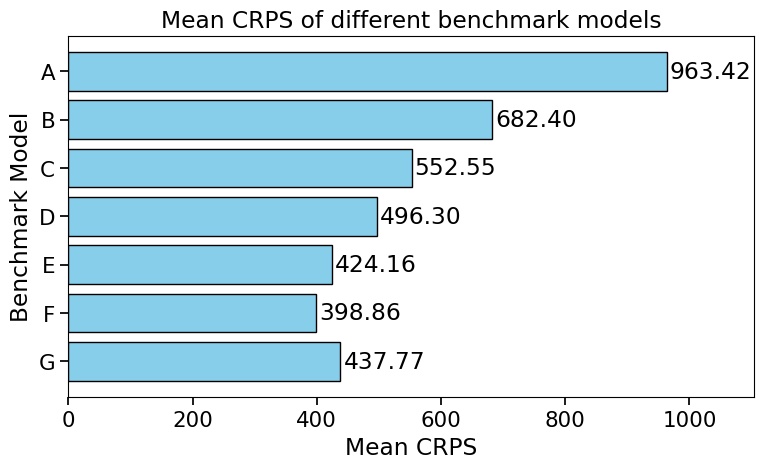

In [86]:
# Create horizontal bar chart
plt.figure(figsize=(8, 5))
plt.barh(labels_splits, crps_splits_best_bm, color='skyblue', edgecolor='black')

# Add labels and title
plt.ylabel("Benchmark Model")  
plt.xlabel("Mean CRPS")
plt.title("Mean CRPS of different benchmark models")
plt.xlim(0, max(crps_splits_best_bm) + 140)  

# Show values on bars 
for i, v in enumerate(crps_splits_best_bm):
    plt.text(v + 5, i, f"{v:.2f}", va='center')  

plt.tight_layout()
plt.gcf().savefig(base_path_plots / "splits_to_best_bm.png")
plt.show()

In [87]:
std_bike_count = df_train['bike_count'].std()
mean_bike_count = df_train['bike_count'].mean()

In [88]:
def calculate_pit(y_pred, y_true):
    sorted_preds = np.sort(y_pred)
    cdf_value = np.searchsorted(sorted_preds, y_true) / len(y_pred)
    return cdf_value

def calculate_residual(y_pred, y_true):
    residual = y_true - np.mean(y_pred)
    return residual

def calculate_standardized_residual(y_pred, y_true):
    residual = calculate_residual(y_pred, y_true)
    
    if np.std(y_pred) == 0:
        std = std_bike_count
    else:
        std = np.std(y_pred)
    
    std_residual = residual / std

    outlier = abs(std_residual) > 3
    return std_residual, outlier, residual, std, np.mean(y_pred)

def calculate_mean(y_pred):
    return np.mean(y_pred)

def calculate_mse(y_pred, y_true):
    return np.mean((y_true-y_pred) ** 2)

def calculate_std(y_pred):
    return np.std(y_pred)   

In [89]:
def prep_for_plots(df, mean_all, std_all):
    all_pit_values = []
    all_residuals = []
    all_standardized_residuals = []
    all_means = []
    y_test_all = []
    all_mse = []
    all_rmse = []
    all_std = []
    outliers = []
    outlier_data = []
    all_n_train_samples = []
    n_unused_training_sets = []
    outlier_std = []

    empty_test_sets = 0
    empty_training_sets = 0
    one_element_training_sets = 0
    number_sets = 0
    empty_test_and_training_sets = 0

    


    # Iterate over the list of [df_train, df_test] pairs
    for df_train1, df_test1 in df:
        number_sets += 1
        std = None

        y_train = df_train1['bike_count'].values  
        y_test = df_test1['bike_count'].values
    
        if y_test.size == 0:
            empty_test_sets += 1
            n_unused_training_sets.append(len(y_train))
            if y_train.size == 0:
                empty_test_and_training_sets += 1
        
            continue

        if y_train.size == 1:
            print("Single-element training set for test set: ")
            one_element_training_sets += 1
            print(df_test1['date'])
            std = [std_all for i in range(len(y_test))]
        elif y_train.size == 0:
            print("Empty training set for test set: ")
            empty_training_sets += 1
            print(df_test1['date'])

            y_train = np.array([mean_all])

        # calculate std
        if std is None:
            std = [calculate_std(y_train) for i in range(len(y_test))]
        all_std.extend(std)

        for i in range(len(y_test)):
            if std[i] > 1500:
                outlier_std.append({
                    'Standard_Deviation': std[i],
                    'True_Value': y_test[i],
                    'date': df_test1['date'].iloc[i],
                    'season': df_test1['season'].iloc[i],
                    'day_of_week': df_test1['day_of_week'].iloc[i],
                    'is_workday': df_test1['is_workday'].iloc[i],
                    'public_holiday': df_test1['public_holiday'].iloc[i],
                    'school_holiday': df_test1['school_holiday'].iloc[i],
                    'Number of Training Samples': len(y_train)
                })


        #for PIT
        # For each test sample, use the corresponding value from y_train as the prediction
        ensemble_predictions = np.tile(y_train, (len(df_test), 1))  # Replicate y_train as predictions for each test instance
        pit_values = [calculate_pit(ensemble_predictions[i, :], y_test[i]) for i in range(len(y_test))]
        all_pit_values.extend(pit_values)

        # for residual
        residuals = [calculate_residual(y_train, y_test[i]) for i in range(len(y_test))]
        all_residuals.extend(residuals)

        for i in range(len(y_test)):
            std_residual, is_outlier, residual, std, mean = calculate_standardized_residual(y_train, y_test[i])
            all_standardized_residuals.append(std_residual)
            outliers.append(is_outlier)
    
            if is_outlier:
                outlier_data.append({
                    'Standardized_Residual': std_residual,
                    'Residual': residual,
                    'True_Value': y_test[i],
                    'Predicted_Mean': mean,
                    'Standard_Deviation': std,
                    'date': df_test1['date'].iloc[i],
                    'season': df_test1['season'].iloc[i],
                    'day_of_week': df_test1['day_of_week'].iloc[i],
                    'is_workday': df_test1['is_workday'].iloc[i],
                    'public_holiday': df_test1['public_holiday'].iloc[i],
                    'school_holiday': df_test1['school_holiday'].iloc[i],
            
            
            
            'Number of Training Samples': len(y_train)
            })
            
        

        #for mean
        mean = [calculate_mean(y_train) for i in range(len(y_test))]
        all_means.extend(mean)

        y_test_all.extend(y_test)

        # Calculate the mean squared error
        mse =  [calculate_mse(mean, y_test[i]) for i in range(len(y_test))]
        all_mse.extend(mse)

        # Calculate the root mean squared error
        rmse = np.sqrt(mse)
        all_rmse.extend(rmse)

        all_n_train_samples.extend([len(y_train) for i in range(len(y_test))])
    
    outlier_df = pd.DataFrame(outlier_data)
    outlier_std_df = pd.DataFrame(outlier_std)
    print("Number of sets: ", number_sets)
    print("Number of empty test sets: ", empty_test_sets)
    print("Number of empty training sets: ", empty_training_sets)
    print("Number of single-element training sets: ", one_element_training_sets)
    print("Number of empty test and training sets: ", empty_test_and_training_sets)
    print("Number of unused training data samples: ", np.sum(n_unused_training_sets))
    print("Average number of training data samples: ", np.mean(all_n_train_samples))
    print("Shape of n_train_samples: ", np.array(all_n_train_samples).shape)

    return all_pit_values, all_residuals, all_standardized_residuals, all_means, y_test_all, all_mse, all_rmse, all_std, outlier_df, outlier_std_df

In [90]:
all_pit_values, all_residuals, all_standardized_residuals, all_means, y_test_all, all_mse, all_rmse, all_std, outlier_df, outlier_std_df = prep_for_plots(dfs_split_by_weekdays_season_and_rain_ph_schoolh, mean_bike_count, std_bike_count)

Single-element training set for test set: 
302   2023-10-30
Name: date, dtype: datetime64[ns]
Single-element training set for test set: 
365   2024-01-01
Name: date, dtype: datetime64[ns]
Empty training set for test set: 
304   2023-11-01
Name: date, dtype: datetime64[ns]
Single-element training set for test set: 
370   2024-01-06
Name: date, dtype: datetime64[ns]
Number of sets:  224
Number of empty test sets:  115
Number of empty training sets:  1
Number of single-element training sets:  3
Number of empty test and training sets:  55
Number of unused training data samples:  252
Average number of training data samples:  41.87435897435898
Shape of n_train_samples:  (390,)


In [91]:
len(df_train)

3525

In [92]:
outlier_std_df

,Standard_Deviation,True_Value,date,season,day_of_week,is_workday,public_holiday,school_holiday,Number of Training Samples
0,1947.650175,4411.0,2023-10-30,2,0,1,No Holiday,herbstferien,1
1,1947.650175,894.0,2024-01-01,3,0,0,Neujahr,weihnachtsferien,1
2,1947.650175,1300.0,2024-01-06,3,5,0,Heilige Drei Koenige,No Holiday,1


In [93]:
outlier_std_df.to_latex(r"data\outlier_std_benchmark_df.tex", index=False)

In [94]:
outlier_df

,Standardized_Residual,Residual,True_Value,Predicted_Mean,Standard_Deviation,date,season,day_of_week,is_workday,public_holiday,school_holiday,Number of Training Samples
0,-5.372881,-158.500000,2144.0,2302.500000,29.500000,2023-10-03,2,1,0,Tag der Deutschen Einheit,No Holiday,2
1,6.315789,240.000000,671.0,431.000000,38.000000,2023-12-26,3,1,0,Weihnachten,weihnachtsferien,2
2,-3.025575,-591.500000,2165.0,2756.500000,195.500000,2023-06-08,1,3,0,Fronleichnam,pfingstferien,2
3,3.164286,443.000000,1322.0,879.000000,140.000000,2023-04-07,0,4,0,Karfreitag,No Holiday,2
4,8.799337,795.333333,1574.0,778.666667,90.385594,2023-01-06,3,4,0,Heilige Drei Koenige,weihnachtsferien,3
5,6.738430,627.000000,1160.0,533.000000,93.048375,2023-01-01,3,6,0,Neujahr,weihnachtsferien,3


In [95]:
outlier_df.to_latex(r"data\outlier_benchmark_df.tex", index=False)

In [96]:
mean_rmse = np.mean(all_rmse)
mean_std = np.mean(all_std)

spread_skill_ratio = mean_std / mean_rmse

In [97]:
print(f'Mean MSE: {np.mean(all_mse)}')
print(f'Mean RMSE: {np.mean(all_rmse)}')
print(f'Mean Residuals: {np.mean(all_residuals)}')
print(f'Mean Standardized Residuals: {np.mean(all_standardized_residuals)}')
print(f'Mean PIT: {np.mean(all_pit_values)}')
print(f'Spread Skill Ratio: {spread_skill_ratio}')

Mean MSE: 476217.85291900573
Mean RMSE: 515.773355283116
Mean Residuals: -175.5974388915886
Mean Standardized Residuals: -0.12939587668862143
Mean PIT: 0.43476440540134237
Spread Skill Ratio: 1.6454509600091998


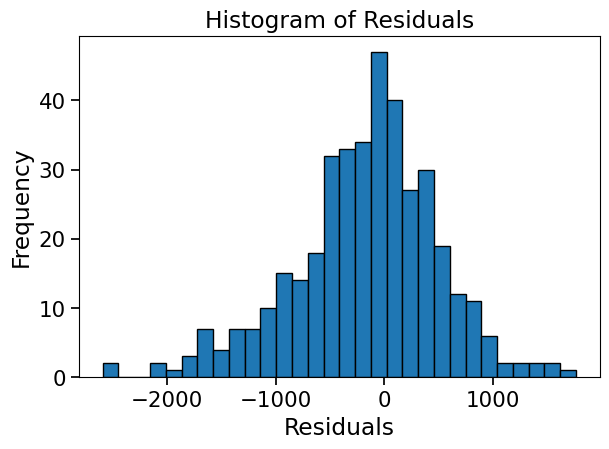

In [98]:
plt.hist(all_residuals, bins=30, edgecolor='k')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.gcf().savefig(base_path_plots / "residuals_hist.png")
plt.show()

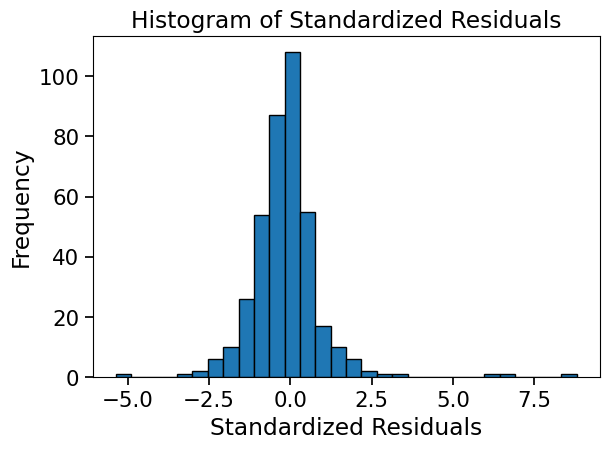

In [99]:
residuals_histogramm = plt.hist(all_standardized_residuals, bins=30, edgecolor='k')
plt.title("Histogram of Standardized Residuals")
plt.xlabel("Standardized Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.gcf().savefig(base_path_plots / "standardized_residuals_hist.png")
plt.show()
plt.close()

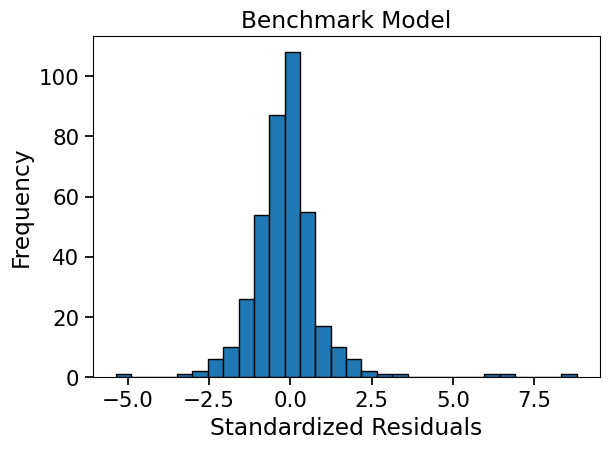

In [100]:
residuals_histogramm = plt.hist(all_standardized_residuals, bins=30, edgecolor='k')
plt.title("Benchmark Model")
plt.xlabel("Standardized Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.gcf().savefig(base_path_plots / "standardized_residuals_hist_benchmark.png")
plt.show()
plt.close()

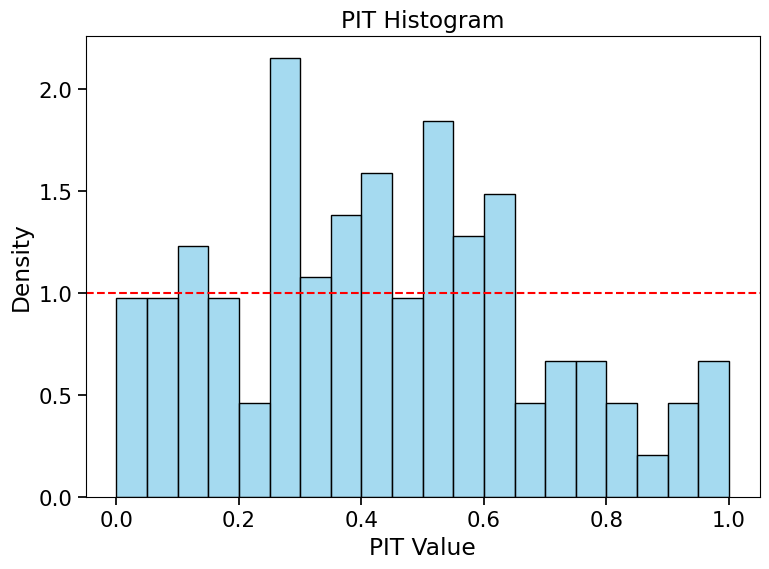

In [101]:
plt.figure(figsize=(8, 6))
sns.histplot(all_pit_values, bins=20, kde=False, stat='density', edgecolor='k', color='skyblue')
plt.axhline(1, color='red', linestyle='--', linewidth=1.5, label='Density = 1') 

plt.title('PIT Histogram')
plt.xlabel('PIT Value')
plt.ylabel('Density')
plt.tight_layout()
plt.gcf().savefig(base_path_plots / "pit_histogram.png")
plt.show()

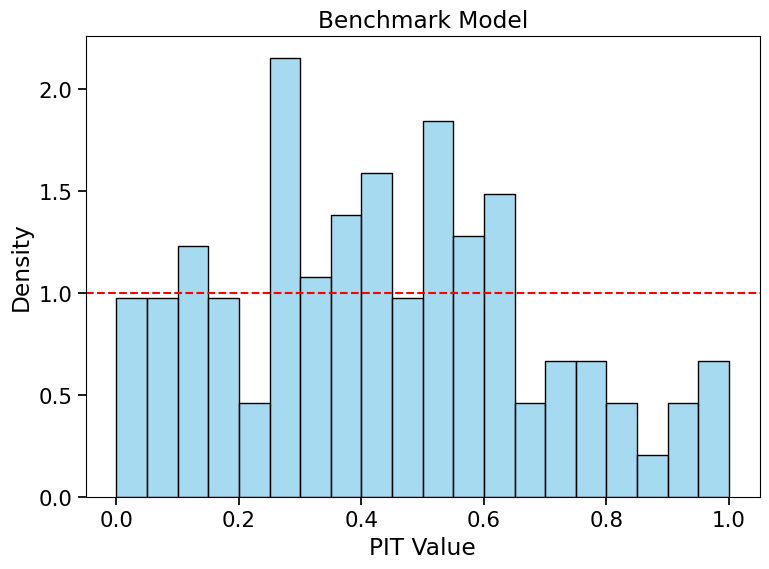

In [102]:
plt.figure(figsize=(8, 6))
sns.histplot(all_pit_values, bins=20, kde=False, stat='density', edgecolor='k', color='skyblue')
plt.axhline(1, color='red', linestyle='--', linewidth=1.5, label='Density = 1') 

plt.title('Benchmark Model')
plt.xlabel('PIT Value')
plt.ylabel('Density')
plt.tight_layout()
plt.gcf().savefig(base_path_plots / "pit_histogram_benchmark.png")
plt.show()

p-value: 0.03368473673767037


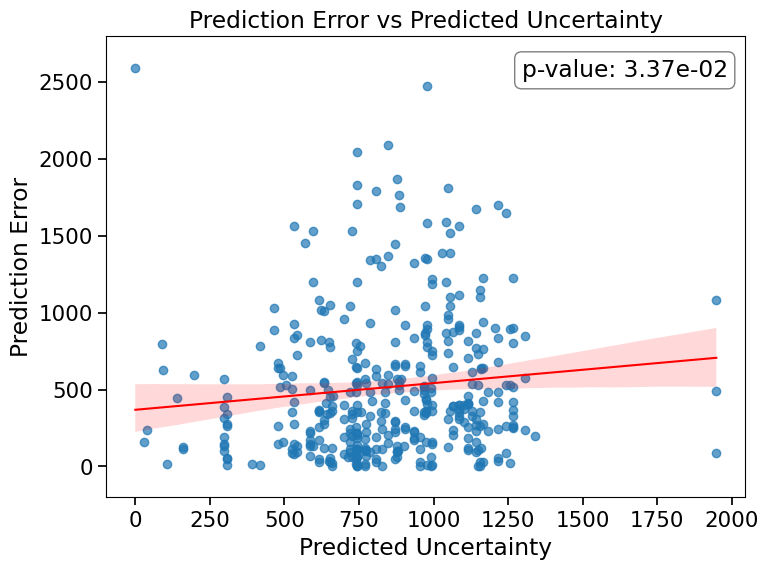

In [103]:
errors = np.abs(all_residuals)

plt.figure(figsize=(8, 6))
# Scatter plot
plt.scatter(all_std, errors, alpha=0.7)
plt.xlabel("Predicted Uncertainty")
plt.ylabel("Prediction Error")
plt.title("Prediction Error vs Predicted Uncertainty")

sns.regplot( x=all_std, y=errors, scatter=False, color='red')

# Calculate the p-value for the regression
slope, intercept, r_value, p_value, std_err = stats.linregress(all_std, errors)
print(f'p-value: {p_value}')
plt.ylim(-200, 2800)
# Add the p-value to the plot
plt.text(0.65, 0.95, f'p-value: {p_value:.2e}', transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))


plt.tight_layout()
plt.gcf().savefig(base_path_plots / "uncertainty_error_scatter.png")
# Show plot
plt.show()

p-value: 0.03368473673767037


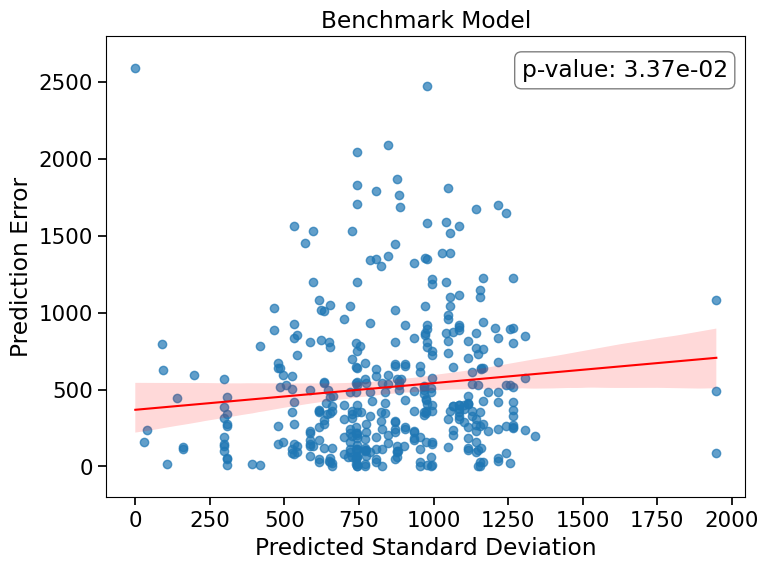

In [104]:
errors = np.abs(all_residuals)

plt.figure(figsize=(8, 6))
# Scatter plot
plt.scatter(all_std, errors, alpha=0.7)
plt.xlabel("Predicted Standard Deviation")
plt.ylabel("Prediction Error")
plt.title("Benchmark Model")
plt.ylim(-200, 2800)

sns.regplot( x=all_std, y=errors, scatter=False, color='red')

# Calculate the p-value for the regression
slope, intercept, r_value, p_value, std_err = stats.linregress(all_std, errors)
print(f'p-value: {p_value}')
# Add the p-value to the plot
plt.text(0.65, 0.95, f'p-value: {p_value:.2e}', transform=plt.gca().transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))


plt.tight_layout()
plt.gcf().savefig(base_path_plots / "uncertainty_error_scatter_benchmark.png")
# Show plot
plt.show()

In [105]:
# Calculate prediction intervals (95% confidence interval)
lower_bound = np.array(all_means) - 1.96 * np.array(all_std)
upper_bound = np.array(all_means) + 1.96 * np.array(all_std)

# Check how many actual values fall within the prediction interval
coverage = np.mean((y_test_all >= lower_bound) & (y_test_all <= upper_bound))

print(f"PICP (Prediction Interval Coverage Probability): {coverage:.2f}")

#picp represents the percentage of actual values that fall within the prediction interval
# 95 percent of true values fall within 95% of the prediction interval

PICP (Prediction Interval Coverage Probability): 0.95


In [106]:
all_means = np.array(all_means)
print(all_means.shape)

(390,)


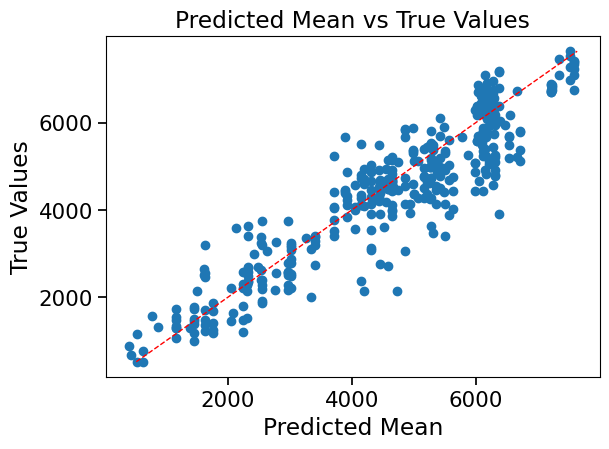

In [107]:
# Scatter plot
plt.scatter(all_means, y_test_all)
plt.plot([min(y_test_all), max(y_test_all)], [min(y_test_all), max(y_test_all)], color='red', linestyle='--')
plt.title("Predicted Mean vs True Values")
plt.xlabel("Predicted Mean")
plt.ylabel("True Values")

plt.tight_layout()  
plt.gcf().savefig(base_path_plots / "predicted_mean_vs_true_values.png")
plt.show()

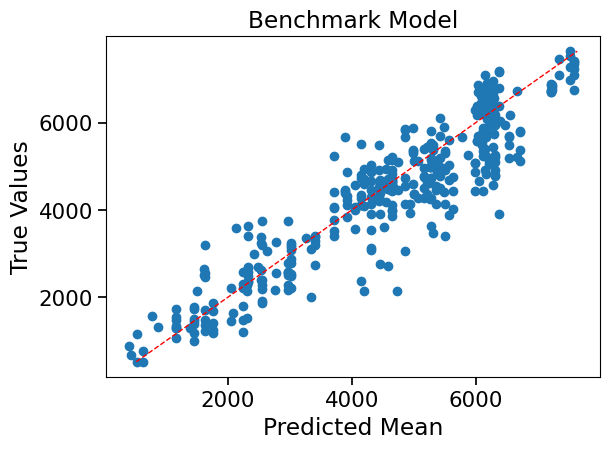

In [108]:
# Scatter plot
plt.scatter(all_means, y_test_all)
plt.plot([min(y_test_all), max(y_test_all)], [min(y_test_all), max(y_test_all)], color='red', linestyle='--')
plt.title("Benchmark Model")
plt.xlabel("Predicted Mean")
plt.ylabel("True Values")

plt.tight_layout()  
plt.gcf().savefig(base_path_plots / "predicted_mean_vs_true_values_benchmark.png")
plt.show()

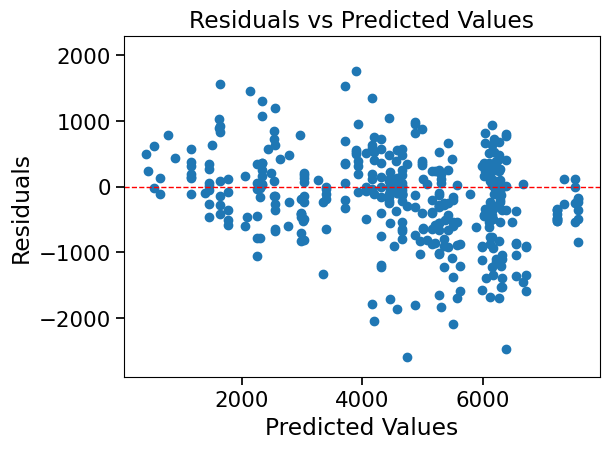

In [109]:

res_vs_pred_plot = plt.scatter(all_means, all_residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Horizontale Linie bei 0
plt.ylim(-2900, 2300)

plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.gcf().savefig(base_path_plots / "residuals_vs_predicted_values.png")
plt.show()

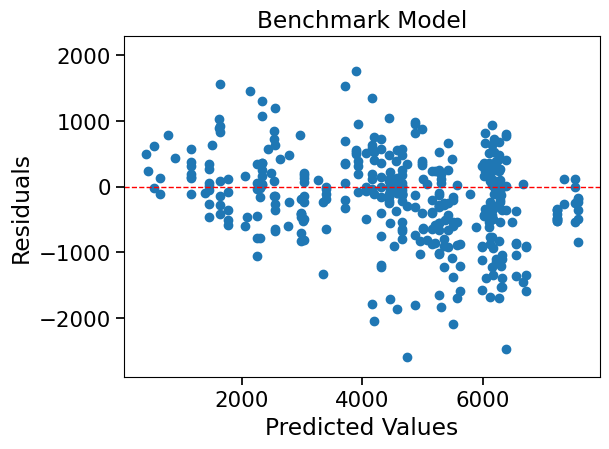

In [110]:

res_vs_pred_plot = plt.scatter(all_means, all_residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Horizontale Linie bei 0
plt.ylim(-2900, 2300)

plt.title("Benchmark Model")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.gcf().savefig(base_path_plots / "residuals_vs_predicted_values_benchmark.png")
plt.show()

In [111]:
all_pit_values1, all_residuals1, all_standardized_residuals1, all_means1, y_test_all1, all_mse1, all_rmse1, all_std1, outlier_df1, outlier_std_df1 = prep_for_plots(dfs_split_by_weekdays_season_and_rain_ph, mean_bike_count, std_bike_count)

Single-element training set for test set: 
304   2023-11-01
Name: date, dtype: datetime64[ns]
Number of sets:  112
Number of empty test sets:  43
Number of empty training sets:  0
Number of single-element training sets:  1
Number of empty test and training sets:  13
Number of unused training data samples:  64
Average number of training data samples:  60.756410256410255
Shape of n_train_samples:  (390,)


In [112]:
all_pit_values2, all_residuals2, all_standardized_residuals2, all_means2, y_test_all2, all_mse2, all_rmse2, all_std2, outlier_df2, outlier_std_df2 = prep_for_plots(dfs_split_by_weekdays_season_and_rain_ph_schoolh_windspeed, mean_bike_count, std_bike_count)

Single-element training set for test set: 
99   2023-04-10
Name: date, dtype: datetime64[ns]
Single-element training set for test set: 
148   2023-05-29
Name: date, dtype: datetime64[ns]
Single-element training set for test set: 
302   2023-10-30
Name: date, dtype: datetime64[ns]
Single-element training set for test set: 
358   2023-12-25
Name: date, dtype: datetime64[ns]
Empty training set for test set: 
365   2024-01-01
Name: date, dtype: datetime64[ns]
Single-element training set for test set: 
275   2023-10-03
Name: date, dtype: datetime64[ns]
Single-element training set for test set: 
303   2023-10-31
Name: date, dtype: datetime64[ns]
Single-element training set for test set: 
359   2023-12-26
Name: date, dtype: datetime64[ns]
Single-element training set for test set: 
366   2024-01-02
Name: date, dtype: datetime64[ns]
Single-element training set for test set: 
102   2023-04-13
Name: date, dtype: datetime64[ns]
Single-element training set for test set: 
158   2023-06-08
Name: date

In [113]:
all_pit_values3, all_residuals3, all_standardized_residuals3, all_means3, y_test_all3, all_mse3, all_rmse3, all_std3, outlier_df3, outlier_std_df3 = prep_for_plots(dfs_split_by_weekdays_season_rain_schoolh, mean_bike_count, std_bike_count)

Single-element training set for test set: 
302   2023-10-30
Name: date, dtype: datetime64[ns]
Number of sets:  112
Number of empty test sets:  13
Number of empty training sets:  0
Number of single-element training sets:  1
Number of empty test and training sets:  0
Number of unused training data samples:  166
Average number of training data samples:  43.84102564102564
Shape of n_train_samples:  (390,)


In [114]:
all_pit_values4, all_residuals4, all_standardized_residuals4, all_means4, y_test_all4, all_mse4, all_rmse4, all_std4, outlier_df4, outlier_std_df4 = prep_for_plots(dfs_split_by_weekdays_season_and_rain, mean_bike_count, std_bike_count)

Number of sets:  56
Number of empty test sets:  0
Number of empty training sets:  0
Number of single-element training sets:  0
Number of empty test and training sets:  0
Number of unused training data samples:  0.0
Average number of training data samples:  64.73846153846154
Shape of n_train_samples:  (390,)


In [115]:
all_pit_values5, all_residuals5, all_standardized_residuals5, all_means5, y_test_all5, all_mse5, all_rmse5, all_std5, outlier_df5, outlier_std_df5 = prep_for_plots(dfs_split_by_weekdays, mean_bike_count, std_bike_count)

Number of sets:  7
Number of empty test sets:  0
Number of empty training sets:  0
Number of single-element training sets:  0
Number of empty test and training sets:  0
Number of unused training data samples:  0.0
Average number of training data samples:  503.56666666666666
Shape of n_train_samples:  (390,)


In [116]:
all_pit_values6, all_residuals6, all_standardized_residuals6, all_means6, y_test_all6, all_mse6, all_rmse6, all_std6, outlier_df6, outlier_std_df6 = prep_for_plots(dfs_split_by_weekdays_and_seasons, mean_bike_count, std_bike_count)

Number of sets:  28
Number of empty test sets:  0
Number of empty training sets:  0
Number of single-element training sets:  0
Number of empty test and training sets:  0
Number of unused training data samples:  0.0
Average number of training data samples:  125.55128205128206
Shape of n_train_samples:  (390,)
